In [26]:
from PIL import Image
import cv2
import glob
from scipy.interpolate import interp2d
#warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
from scipy.interpolate import CubicSpline
from ripser import ripser 
from persim import plot_diagrams
from time import time

from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import os
from pathlib import Path


import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy import interpolate

In [27]:
# Auxiliary video functions
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()

def playVideo(filepath):
    cap = cv2.VideoCapture(filepath)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('frame', frame)
        if cv2.waitKey(24) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()  

def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    n_row, n_col, _ = image.shape
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)

In [28]:
def loadFrame(framefilepath): 
    image_path = framefilepath
    image = cv2.imread(image_path)
    
    # Split the image into RGB channels
    blue_channel, green_channel, red_channel = cv2.split(image)

    pixels = image.reshape(-1, 3)
    
    return pixels 

In [354]:
# Define the function you want to graph
def f(x):
    return 1*np.cos((1*np.pi)*x) + 1*np.cos((1)*x)

# Create the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6), linewidth=10)  # Adjust the figsize to change the dimensions

# Create line objects for the functions
lines = []
num_functions = 1  # Number of functions to plot
linewidth=10

# Set the x and y limits of the plot
ax.set_xlim(0, 500)
ax.set_ylim(-10, 10 * (num_functions + 1))

for i in range(num_functions):
    line, = ax.plot([], [], linewidth=linewidth)
    lines.append(line)

# Define the initialization function for the animation
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# Define the update function for the animation
def update(frame):
    x = np.linspace(0, frame, 1000)  # Increase the domain value in each frame
    for i, line in enumerate(lines):
        y = f(x) + i * 20  # Vertical shift by 10 units for each additional function
        line.set_data(x, y)
    return lines

# Calculate the increment to get exactly 250 frames
total_frames = 250
final_frame = 500
increment = final_frame / (total_frames - 1)

# Generate the frames at the calculated increment
frames = np.arange(0, final_frame + increment, increment)

# Create a directory to store the frames
output_folder = 'frames_2'
os.makedirs(output_folder, exist_ok=True)

# Save only the last frame as an image file with larger dimensions
last_frame = frames[-1]
fig.set_size_inches(300, 1)  # Set larger dimensions for the last frame
update(last_frame)
ax.axis('off')  # Hide the axes
ax.grid(True, linestyle='dashed', alpha=0.5)  # Display the grid lines
fig.canvas.draw()
output_filename = os.path.join(output_folder, 'last_frame.png')
fig.savefig(output_filename, dpi=fig.dpi)

# Cleanup: close the figure
plt.close(fig)


In [355]:
import os
from PIL import Image

# Load the original frame
frame = Image.open("/Users/slmathuser/frames_2/last_frame.png")

# Define the slice width and original frame dimensions
slice_width = 200
frame_width, frame_height = frame.size

# Calculate the number of vertical slices
num_slices = frame_width // slice_width

# Create a folder to save the slices
slices_folder = "/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2"
os.makedirs(slices_folder, exist_ok=True)

# Iterate over the slices and extract each vertical slice
for i in range(num_slices):
    left = i * slice_width
    upper = 0
    right = (i + 1) * slice_width
    lower = frame_height

    slice_image = frame.crop((left, upper, right, lower)).convert("RGB")  # Convert to RGB mode
    slice_image.save(os.path.join(slices_folder, f"slice_{i}.jpg"))  # Save each slice to the folder


In [374]:
import os
import glob

# Specify the path to the input folder
folder_path = "/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2"
# Get a list of file names in the folder
file_names = glob.glob(os.path.join(folder_path, "*.jpg"))

# Define the custom sorting key function
def get_file_number(file_path):
    # Extract the number from the file name
    try:
        file_name = os.path.basename(file_path)  # Extract the file name from the full path
        number = int(file_name.split('.')[0].replace('slice_', ''))  # Assuming the number is before the file extension
    except ValueError:
        number = float('inf')  # Assign a high value if the file name doesn't contain a number
    return number

# Sort the file names based on the custom sorting key
sorted_file_names = sorted(file_names, key=get_file_number)

In [375]:
filepath_list=[]
# Iterate over the sorted file names
for file_name in sorted_file_names:
    file_path = os.path.join(folder_path, file_name)
    #new_file_path = file_path.replace('\\', '\\\\')  # Add an extra backslash to each backslash
    filepath_list.append(file_path)
filepath_array=np.array(filepath_list)

print(filepath_array)

['/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_18.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_19.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_20.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_21.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_22.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_23.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_24.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_25.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_26.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_27.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_28.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_29.jpg'
 '/Users/slmathuser/Documents/GitHub/TTSA-Project-3/slices_2/slice_30.jpg'
 '/Users/slmathuser/Docum

In [376]:
pixels_matrix=[]
for path in filepath_array: 
    pixels=loadFrame(path)
    pixels_matrix.append(pixels)
pixels_matrix=np.array(pixels_matrix)

In [377]:
pixel_list=[]
for i in range(len(pixels_matrix)): 
    arr=pixels_matrix[i]
    flatten_arr = arr.flatten()
    pixel_list.append(flatten_arr)
pixel_list=np.array(pixel_list)
print(pixel_list.shape)

(117, 60000)


In [378]:
writeVideo("pilot.mp4", pixel_list, 10, (100,200))

In [379]:
#Storing Video Data into Data Variable
data, shape = loadVideo("/Users/slmathuser/pilot.mp4")

117  frames extracted
frame size =  (100, 200)
data shape = (117, 60000)


In [387]:
#Construct the sliding window pointcloud of video data
wSize = 18
dim = 5
Tau = wSize/float(dim)


data=data
desiredSamples = 1000
M = data.shape[0] - wSize + 1
dT = M/float(desiredSamples)

X = getSlidingWindowVideo(data, dim, Tau, dT)

XS = X - np.mean(X, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

X = X - np.amin(X)
X = X/np.amax(X)
X = np.uint8(X*255)
frame_data = X[:, 0:data.shape[1]]

/var/folders/cy/j26w4bs96qx4s7nvml4d4hdm0000gp/T/ipykernel_99565/213991029.py:13: DeprecationWarning:

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`


/var/folders/cy/j26w4bs96qx4s7nvml4d4hdm0000gp/T/ipykernel_99565/213991029.py:14: DeprecationWarning:

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.



In [431]:
print(X.shape)

(990, 300000)


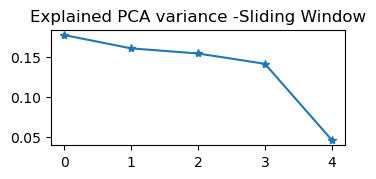

In [388]:
# PCA of the Sliding window point cloud
pca = PCA(n_components=5)
XS_pca = pca.fit(XS).transform(XS)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');

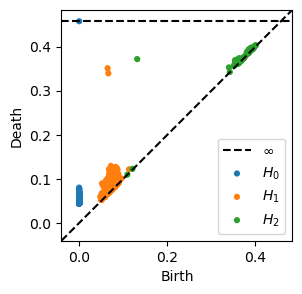

In [389]:
# Compute persistence diagrams of the pca vesion of the sliding window point cloud
res = ripser(XS_pca, maxdim=2, n_perm =500, coeff =3, thresh = 0.9)
dgms = res['dgms']
plt.figure(figsize = (3,3)) 
plot_diagrams(dgms)


In [370]:
#Applying Dreimac 

#topological data analysis
from dreimac import CircularCoords 
from persim import plot_diagrams
from dreimac import CircleMapUtils as CMU


/Users/slmathuser/anaconda3/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?



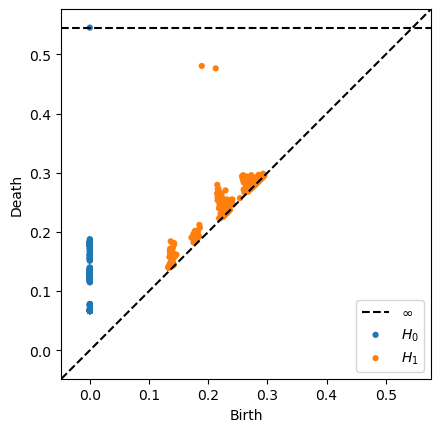

In [390]:
n_lands = 600

cc = CircularCoords(XS, n_landmarks=n_lands)

plot_diagrams(cc.dgms_)

In [438]:
# Get the circular coordinates at birth, and for the 2 cocycles with highest persistence
coho_classes = [0]

circular_coords = []

for i in coho_classes:
    #perc: specifies the time in filtration to construct the coordinates 
    #cocyle_index: Picks a persistent homology class when the classes are ordered with respect to persistence
    theta = cc.get_coordinates(perc= 0, cocycle_idx=i)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)

#Overall, this code snippet retrieves the circular coordinates associated with the specified cohomology classes and performs 
#some transformation on them.

In [439]:
# Plot data with 2 circular coordinates

fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=XS_pca[:,0], y=XS_pca[:,1], z=XS_pca[:,2],   mode ='markers', 
        marker=dict(size = 2 , color =  circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show()

In [440]:
#Gathering Angle Values Corresponding to Cohomology Classes
thetavals=[]
for i in range(len(circular_coords)):
    list=[]
    for j in range(len(circular_coords[i])): 
        theta=np.arctan2(circular_coords[i][j][1], circular_coords[i][j][0])
        list.append(theta)
    thetavals.append(list)
    
thetavals=np.array(thetavals)

In [450]:
#Sorting Data based on Theta Values
# Pair the elements from all matrices
angle_pairs = np.column_stack([thetas.flatten() for thetas in thetavals])

# Sort the pairs based on lexicographic order
sorted_indices = np.lexsort([angle_pairs[:, i] for i in range(len(coho_classes))])


In [451]:
print(len(sortedindexes[0]))
print(len(sorted_indices))

990
990
